<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr1/blob/main/Kiparenko%20Nikolai/INSPECTRUM_CLINIC_HR_RECSYS_GR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Работа с массивами данных
import numpy as np 

# Работа с таблицами
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation 

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Заполнение последовательностей до определенной длины
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Кодирование тестовых меток
from sklearn.preprocessing import LabelEncoder

# Разбиение на тренировочную и тестовую выборки
from sklearn.model_selection import train_test_split

# автоматически парсит строку и сохранит ее в переменной datetime
import datetime

# Загрузка датасетов из облака google
import gdown

# Функции операционной системы
import os

# Работа со временем
import time

# Регулярные выражения
import re

# Запись в файлы и чтение из файлов структур данных Python
import pickle

# Отрисовка графиков
import matplotlib.pyplot as plt


%matplotlib inline

In [3]:
import gdown                                      # Подключим функцию gdown
gdown.download('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_HR/datasets/%D0%94%D0%B0%D1%82%D0%B0%D0%A1%D0%B5%D1%82%20%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0%20%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5%20581%20%D1%80%D0%B5%D0%B7%D1%8E%D0%BC%D0%B5.xlsx','dataS.xlsx', quiet=True)   

'dataS.xlsx'

In [14]:
data = pd.read_excel (r'dataS.xlsx', index_col=0)
data.max_columns = 30
data.columns = ['Response_date', 'Full_name', 'Gender', 'Salary', 'Job', 'City', 'Employment', 'Schedule', 'Experience', 'Last_place', 'Position', 'Education', 'Update_resume', 'Suitable']

In [ ]:
data.head(5)

In [5]:
month_name = {1: 'января', 2: 'февраля', 3: 'марта', 4: 'апреля', 5: 'мая', 6: 'июня',
      7: 'июля', 8: 'августа', 9: 'сентября', 10: 'октября', 11: 'ноября', 12: 'декабря'}


In [15]:
Birth = data['Gender'].apply(lambda x: x.split(',')[2].strip() if len(x.split(','))>2 else '')
data = data.assign(Birth=Birth)

Age = data['Gender'].apply(lambda x: x.split(',')[1].strip() if len(x.split(','))>1 else '')
data = data.assign(Age=Age)


In [ ]:
for i, row in data.iterrows():
  #Gender
  row.Gender = row.Gender.split(',')[0].strip() 
  #Женщина = 0, Мужчина = 1
  row.Gender = row.Gender.replace('Женщина','0')
  row.Gender = row.Gender.replace('Мужчина','1')
  row.Gender = int(row.Gender)

  #Birth
  row.Birth = row.Birth.replace('родился','')
  row.Birth = row.Birth.replace('родилась','')
 
  #Age
  row.Age = row.Age.replace('года','')
  row.Age = row.Age.replace('год','')
  row.Age = row.Age.replace('лет','')
  row.Age = row.Age='' if 0 else row.Age

  try:
    row.Age = int(row.Age)
  except (IndexError, TypeError, ValueError):
    print(row.Age)
    row.Age = 0

  #Salary
  row.Salary = row.Salary.replace(' ','') 
  row.Salary = str(float(row.Salary.replace('KGS',''))*0.89)      if row.Salary.find('KGS') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('KZT',''))*0.18)      if row.Salary.find('KZT') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('USD',''))*78.00)     if row.Salary.find('USD') != -1 else row.Salary
  row.Salary = str(float(row.Salary.replace('EUR',''))*85.00)     if row.Salary.find('EUR') != -1 else row.Salary
  row.Salary = row.Salary.replace('руб.','')
  row.Salary = row.Salary.replace('руб','')
  row.Salary = row.Salary.replace('неуказана','0')
  row.Salary = int(float(row.Salary)) 

  #Experience
  row.Experience = row.Experience.replace('Опыт работы —','')
  row.Experience = row.Experience.replace('Опыт работы','')
  row.Experience = row.Experience.replace('года',';')
  row.Experience = row.Experience.replace('лет',';')
  row.Experience = row.Experience.replace('годов',';')
  row.Experience = row.Experience.replace('год',';')
  row.Experience = row.Experience.replace('года',';')
  row.Experience = row.Experience.replace('месяцев','')
  row.Experience = row.Experience.replace('месяца','')
  row.Experience = row.Experience.replace('месяц','')
  row.Experience = row.Experience.replace('нет','0')
  #Приводим к месяцам, если были года умножаем на 12 иначе берем как есть 
  row.Experience = (int(row.Experience.split(';')[0].strip()) * 12 + (int(row.Experience.split(';')[1].strip())) if row.Experience.split(';')[1].strip() != '' else int(row.Experience.split(';')[0].strip()) * 12) if len(row.Experience.split(';')) >1 else int(row.Experience.strip()) 

  #Schedule
  #вахтовый метод = 0, удаленная работа = 1, гибкий график = 2, полный день = 3, сменный график = 4
  row.Schedule = row.Schedule.replace('вахтовый метод','0')
  row.Schedule = row.Schedule.replace('удаленная работа','1')
  row.Schedule = row.Schedule.replace('гибкий график','2')
  row.Schedule = row.Schedule.replace('полный день','3')
  row.Schedule = row.Schedule.replace('сменный график','4')

  #Employment
  #проектная работа = 0, неполный рабочий день = 1, полный рабочий день = 2, полная занятость = 3, частичная занятость = 4, стажировка = 5, волонтерство = 6
  row.Employment = row.Employment.replace('проектная работа','0')
  row.Employment = row.Employment.replace('неполный рабочий день','1')
  row.Employment = row.Employment.replace('полный рабочий день','2')
  row.Employment = row.Employment.replace('полная занятость','3')
  row.Employment = row.Employment.replace('частичная занятость','4')
  row.Employment = row.Employment.replace('стажировка','5')
  row.Employment = row.Employment.replace('волонтерство','6')

  #Birth
  for i in month_name:
     row.Birth         = row.Birth.replace(month_name[i],'-'+str(i)+'-')
 
  row.Birth         = row.Birth.replace('родился','')
  row.Birth         = row.Birth.replace('родилась','')
  row.Birth         = row.Birth.replace(' -','-')
  row.Birth         = row.Birth.replace('- ','-')
  row.Birth         = row.Birth+' 00:00:00'

  row.Birth = '1-1-1' +row.Birth if row.Birth == ' 00:00:00' else row.Birth
  day = int(row.Birth.split('-')[0].strip()) 
  month = int(row.Birth.split('-')[1].strip()) 
  year = row.Birth.split('-')[2].strip() 
  time = year.split(' ')[1].strip()
  year = int(year.split(' ')[0].strip())

  row.Birth = int(datetime.datetime(year,month,day).utcnow().timestamp())

  #Update_resume 
  for i in month_name:
    row.Update_resume = row.Update_resume.replace(month_name[i],'-'+str(i)+'-')
 
  row.Update_resume = row.Update_resume.replace('в','')
  row.Update_resume = row.Update_resume.replace(' -','-')
  row.Update_resume = row.Update_resume.replace('- ','-')
  row.Update_resume = row.Update_resume+':00'

  day = int(row.Update_resume.split('-')[0].strip()) 
  month = int(row.Update_resume.split('-')[1].strip()) 
  year = row.Update_resume.split('-')[2].strip() 
  year = year.replace('  ',';')
  year = year.replace(' ',';')
   
  time = year.split(';')[1].strip()
  year = int(year.split(';')[0].strip())
  hour = int(time.split(':')[0].strip())
  minute = int(time.split(':')[1].strip())

  row.Update_resume = int(datetime.datetime(year,month,day,hour,minute,0).utcnow().timestamp())

  #Response_date
  row.Response_date = int(datetime.datetime.utcnow().timestamp())

In [17]:
#Переведем в бинарные значения

#проектная работа = 0, неполный рабочий день = 1, полный рабочий день = 2, полная занятость = 3, частичная занятость = 4, стажировка = 5, волонтерство = 6
Employment_0 = data['Employment'].apply(lambda x: 1 if x.find('0') else 0)
Employment_1 = data['Employment'].apply(lambda x: 1 if x.find('1') else 0)
Employment_2 = data['Employment'].apply(lambda x: 1 if x.find('2') else 0)
Employment_3 = data['Employment'].apply(lambda x: 1 if x.find('3') else 0)
Employment_4 = data['Employment'].apply(lambda x: 1 if x.find('4') else 0)
Employment_5 = data['Employment'].apply(lambda x: 1 if x.find('5') else 0)
Employment_6 = data['Employment'].apply(lambda x: 1 if x.find('6') else 0)

data = data.assign(Employment_0=Employment_0,
                    Employment_1=Employment_1,
                    Employment_2=Employment_2,
                    Employment_3=Employment_3,
                    Employment_4=Employment_4,
                    Employment_5=Employment_5,
                    Employment_6=Employment_6)

#вахтовый метод = 0, удаленная работа = 1, гибкий график = 2, полный день = 3, сменный график = 4
Schedule_0 = data['Schedule'].apply(lambda x: 1 if x.find('0') else 0)
Schedule_1 = data['Schedule'].apply(lambda x: 1 if x.find('1') else 0)
Schedule_2 = data['Schedule'].apply(lambda x: 1 if x.find('2') else 0)
Schedule_3 = data['Schedule'].apply(lambda x: 1 if x.find('3') else 0)
Schedule_4 = data['Schedule'].apply(lambda x: 1 if x.find('4') else 0)

data = data.assign(Schedule_0=Schedule_0,
                    Schedule_1=Schedule_1,
                    Schedule_2=Schedule_2,
                    Schedule_3=Schedule_3,
                    Schedule_4=Schedule_4)


In [18]:
data = data.drop(columns=['Schedule', 'Employment'])

In [19]:
#City
tokenizer = Tokenizer(num_words=30, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.City) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
City_Indexes = tokenizer.texts_to_sequences(data.City)
data = data.assign(City=City_Indexes)

In [20]:
#Full_name
tokenizer = Tokenizer(num_words=100, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Full_name)

Full_name_Indexes = tokenizer.texts_to_sequences(data.Full_name) 
data = data.assign(Full_name=Full_name_Indexes)

In [21]:
#Education
tokenizer = Tokenizer(num_words=200, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Education) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Education_Indexes = tokenizer.texts_to_sequences(data.Education) 
data = data.assign(Education=Education_Indexes)

In [22]:
#Job
tokenizer = Tokenizer(num_words=50, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Job) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Job_Indexes = tokenizer.texts_to_sequences(data.Job) 
data = data.assign(Job=Job_Indexes)

In [23]:
#Last_place
tokenizer = Tokenizer(num_words=100, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Last_place) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Last_place_Indexes = tokenizer.texts_to_sequences(data.Last_place) 
data = data.assign(Last_place=Last_place_Indexes)

In [24]:
#Position
tokenizer = Tokenizer(num_words=20, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer.fit_on_texts(data.Position) #"скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности

Position_Indexes = tokenizer.texts_to_sequences(data.Position) 
data = data.assign(Position=Position_Indexes)

In [25]:
#Suitable
#Список ответов делаем
listAnswers = []
#Обработаем отдельно колонку с ответами
for i, row in data.iterrows():
   a = 1 if str(row.Suitable).find('да') != -1 else 0
   listAnswers.append([a])
answers = np.array(listAnswers)
print(answers.shape)

(579, 1)


In [56]:
data = data.drop(columns=['Suitable'])

In [29]:
data.Response_date = data.Response_date.astype('int')
data.Gender = data.Gender.astype('int')
data.Salary = data.Salary.astype('int')
data.Update_resume = data.Update_resume.astype('int')
data.Birth = data.Birth.astype('int')
data.Age = data.Age.astype('int')


In [ ]:
data.info()

In [31]:
#Приведим все списки к однообразию
#Находим максимальную длину
Full_nameMaxI = 0
PositionMaxI = 0
Last_placeMaxI = 0
JobMaxI = 0
EducationMaxI = 0
CityMaxI = 0
for i, row in data.iterrows():
    Full_nameMaxI   = max(Full_nameMaxI,len(row.Full_name))
    PositionMaxI    = max(PositionMaxI,len(row.Position))
    Last_placeMaxI  = max(Last_placeMaxI,len(row.Last_place))
    JobMaxI         = max(JobMaxI,len(row.Job))
    EducationMaxI   = max(EducationMaxI,len(row.Education))
    CityMaxI        = max(CityMaxI,len(row.City))


In [70]:
#обрабатываем данные list
dataList = [] 
for i, row in data.iterrows():
      row.Full_name     = np.array(row.Full_name+[0 for x in range(Full_nameMaxI-len(row.Full_name))])
      row.Position      = np.array(row.Position+[0 for x in range(PositionMaxI-len(row.Position))])
      row.Last_place    = np.array(row.Last_place+[0 for x in range(Last_placeMaxI-len(row.Last_place))])
      row.Job           = np.array(row.Job+[0 for x in range(JobMaxI-len(row.Job))])
      row.Education     = np.array(row.Education+[0 for x in range(EducationMaxI-len(row.Education))])
      row.City          = np.array(row.City+[0 for x in range(CityMaxI-len(row.City))])
      
      #row_data = np.hstack(row)
      row_data = np.hstack([
                            row.Full_name,
                            row.Position,
                            row.Last_place,
                            row.Job,
                            row.Education,
                            row.City,
                            row.Response_date,
                            row.Gender,
                            row.Salary,
                            row.Update_resume,
                            row.Birth,
                            row.Age,
                            row.Employment_0,
                            row.Employment_1,
                            row.Employment_2,
                            row.Employment_3,
                            row.Employment_4,
                            row.Employment_5,
                            row.Employment_6,
                            row.Schedule_0,
                            row.Schedule_1,
                            row.Schedule_2,
                            row.Schedule_3,
                            row.Schedule_4]
                          )
      
      dataList.append(row_data)

dataset = np.array(dataList) #, dtype=np.float
print(dataset.shape)

(579, 213)


In [ ]:
#Смотрим что получилось
data.max_columns = 30
data.head(-15)

In [ ]:
data.to_csv('data.csv')

In [75]:
for row in dataset:
    print(dataset)

[[ 1  1  0 ...  1  1  1]
 [ 1 11 50 ...  1  1  1]
 [ 1 15 39 ...  1  1  1]
 ...
 [ 1 77  1 ...  1  0  1]
 [ 1 30  1 ...  1  1  1]
 [ 1 48  1 ...  1  1  1]]
[[ 1  1  0 ...  1  1  1]
 [ 1 11 50 ...  1  1  1]
 [ 1 15 39 ...  1  1  1]
 ...
 [ 1 77  1 ...  1  0  1]
 [ 1 30  1 ...  1  1  1]
 [ 1 48  1 ...  1  1  1]]
[[ 1  1  0 ...  1  1  1]
 [ 1 11 50 ...  1  1  1]
 [ 1 15 39 ...  1  1  1]
 ...
 [ 1 77  1 ...  1  0  1]
 [ 1 30  1 ...  1  1  1]
 [ 1 48  1 ...  1  1  1]]
[[ 1  1  0 ...  1  1  1]
 [ 1 11 50 ...  1  1  1]
 [ 1 15 39 ...  1  1  1]
 ...
 [ 1 77  1 ...  1  0  1]
 [ 1 30  1 ...  1  1  1]
 [ 1 48  1 ...  1  1  1]]
[[ 1  1  0 ...  1  1  1]
 [ 1 11 50 ...  1  1  1]
 [ 1 15 39 ...  1  1  1]
 ...
 [ 1 77  1 ...  1  0  1]
 [ 1 30  1 ...  1  1  1]
 [ 1 48  1 ...  1  1  1]]
[[ 1  1  0 ...  1  1  1]
 [ 1 11 50 ...  1  1  1]
 [ 1 15 39 ...  1  1  1]
 ...
 [ 1 77  1 ...  1  0  1]
 [ 1 30  1 ...  1  1  1]
 [ 1 48  1 ...  1  1  1]]
[[ 1  1  0 ...  1  1  1]
 [ 1 11 50 ...  1  1  1]
 [ 1 15 39 ...

In [71]:
x_train, x_test, y_train, y_test = train_test_split(dataset, # набор параметров
                                                    answers, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость

In [90]:
# Масштабирование данных
from sklearn.preprocessing import StandardScaler
y_scaler = StandardScaler()
# Нормализация выходных данных по стандартному нормальному распределению
y_train_scaled = y_scaler.fit_transform(y_train)

In [72]:
x_train.shape

(463, 213)

In [91]:
# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Создание последовательной модели
model = Sequential()
#model.add(Dense(100, activation='relu',input_dim=x_train.shape[1]))
model.add(BatchNormalization(input_dim=x_train.shape[1]))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear')) #softmax

# Компиляция модели
#model.compile(loss='binary_crossentropy', 
#              optimizer=Adam(learning_rate=0.001), 
#              metrics=['accuracy'])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

# Обучение сети
history = model.fit(x_train, 
                    y_train_scaled, #y_train
                    batch_size=256, 
                    epochs=20,
                    validation_split=0.15, 
                    verbose=1)

Epoch 1/20
2/2 [==============================] - 1s 214ms/step - loss: 3.3799 - mae: 0.8455 - val_loss: 9806710571008.0000 - val_mae: 3131566.7500
Epoch 2/20
2/2 [==============================] - 0s 51ms/step - loss: 2.9385 - mae: 0.8166 - val_loss: 4702208524288.0000 - val_mae: 2168457.5000
Epoch 3/20
2/2 [==============================] - 0s 35ms/step - loss: 2.0661 - mae: 0.7335 - val_loss: 2940560998400.0000 - val_mae: 1714806.3750
Epoch 4/20
2/2 [==============================] - 0s 34ms/step - loss: 2.0849 - mae: 0.6784 - val_loss: 2055310802944.0000 - val_mae: 1433635.5000
Epoch 5/20
2/2 [==============================] - 0s 34ms/step - loss: 2.4506 - mae: 0.7210 - val_loss: 1536620494848.0000 - val_mae: 1239605.0000
Epoch 6/20
2/2 [==============================] - 0s 34ms/step - loss: 2.0500 - mae: 0.6664 - val_loss: 1187925852160.0000 - val_mae: 1089920.1250
Epoch 7/20
2/2 [==============================] - 0s 52ms/step - loss: 1.7444 - mae: 0.5959 - val_loss: 923080196096.

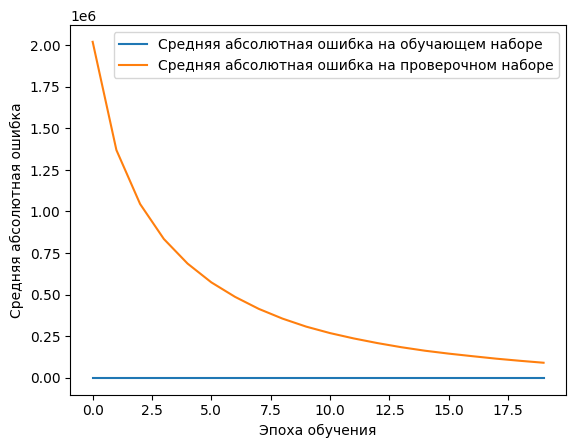

In [89]:
# Визуализация точности на обучающей выборке
plt.plot(history.history['mae'], 
            label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
            label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [92]:
def eval_net(model, x_train, y_train, y_scaler = None, n = 10, limit = 1000.):
  
    pred = model.predict(x_train)             # Предсказание на тренировочной выборке
    if y_scaler:                              # Если есть нормирование - то денормировать
        pred = y_scaler.inverse_transform(pred)

    print('Средняя абсолютная ошибка:', mean_absolute_error(pred, y_train), '\n')

    for i in range(n):
        print('Реальное значение: {:6.2f}  Предсказанное значение: {:6.2f}  Разница: {:6.2f}'.format(y_train[i, 0],
                                                                                                    pred[i, 0],
                                                                                                    abs(y_train[i, 0] - pred[i, 0])))
    # Построение картинки разброса предсказанных и верных значений зарплаты
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_train, pred)                 # Отрисовка точечного графика
    ax.set_xlim(0, limit)                     # Пределы по x, y
    ax.set_ylim(0, limit)
    ax.plot(plt.xlim(), plt.ylim(), 'r')      # Отрисовка диагональной линии
    plt.xlabel('Правильные значения')
    plt.ylabel('Предсказания')
    plt.grid()
    plt.show()     

15/15 [==============================] - 0s 3ms/step
Средняя абсолютная ошибка: 47487.05793567764 

Реальное значение:   0.00  Предсказанное значение: -47487.01  Разница: 47487.01
Реальное значение:   0.00  Предсказанное значение: -47486.61  Разница: 47486.61
Реальное значение:   0.00  Предсказанное значение: -47487.04  Разница: 47487.04
Реальное значение:   0.00  Предсказанное значение: -47487.03  Разница: 47487.03
Реальное значение:   0.00  Предсказанное значение: -47486.52  Разница: 47486.52
Реальное значение:   0.00  Предсказанное значение: -47486.92  Разница: 47486.92
Реальное значение:   0.00  Предсказанное значение: -47486.99  Разница: 47486.99
Реальное значение:   0.00  Предсказанное значение: -47486.84  Разница: 47486.84
Реальное значение:   0.00  Предсказанное значение: -47487.11  Разница: 47487.11
Реальное значение:   0.00  Предсказанное значение: -47486.88  Разница: 47486.88


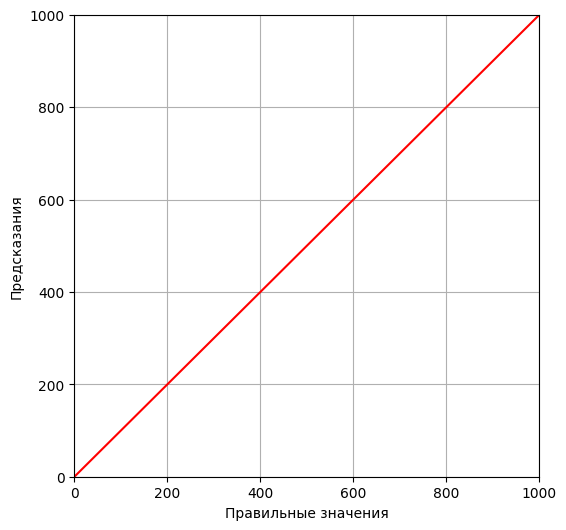

In [93]:


eval_net(model, x_train, y_train, y_scaler)

In [94]:
# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Проверка работы сети - предсказание на тренировочной выборке
pred = model.predict(x_train)

# Расчет среднего значения ошибки 
print((abs(pred - y_train)).mean())         # Расчет вручную
print(mean_absolute_error(pred, y_train))   # Расчет с помощью готовой функции

15/15 [==============================] - 0s 2ms/step
326668.4551160907
326668.4551160907
